<a href="https://colab.research.google.com/github/Ankita-Mishra-2550/Ankita-Mishra-2550/blob/master/Learners_Notebook_Full_Code_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

### Business Context

The healthcare industry is rapidly evolving, with professionals facing increasing challenges in managing vast volumes of medical data while delivering accurate and timely diagnoses. The need for quick access to comprehensive, reliable, and up-to-date medical knowledge is critical for improving patient outcomes and ensuring informed decision-making in a fast-paced environment.

Healthcare professionals often encounter information overload, struggling to sift through extensive research and data to create accurate diagnoses and treatment plans. This challenge is amplified by the need for efficiency, particularly in emergencies, where time-sensitive decisions are vital. Furthermore, access to trusted, current medical information from renowned manuals and research papers is essential for maintaining high standards of care.

To address these challenges, healthcare centers can focus on integrating systems that streamline access to medical knowledge, provide tools to support quick decision-making, and enhance efficiency. Leveraging centralized knowledge platforms and ensuring healthcare providers have continuous access to reliable resources can significantly improve patient care and operational effectiveness.

**Common Questions to Answer**

1. **Critical Care Protocols:** "What is the protocol for managing sepsis in a critical care unit?"

2. **General Surgery:** "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"

3. **Dermatology:** "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"

4. **Neurology:** "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"


### Objective

As an AI specialist, your task is to develop a RAG-based AI solution using renowned medical manuals to address healthcare challenges. The objective is to **understand** issues like information overload, **apply** AI techniques to streamline decision-making, **analyze** its impact on diagnostics and patient outcomes, **evaluate** its potential to standardize care practices, and **create** a functional prototype demonstrating its feasibility and effectiveness.

### Data Description

The **Merck Manuals** are medical references published by the American pharmaceutical company Merck & Co., that cover a wide range of medical topics, including disorders, tests, diagnoses, and drugs. The manuals have been published since 1899, when Merck & Co. was still a subsidiary of the German company Merck.

The manual is provided as a PDF with over 4,000 pages divided into 23 sections.

## Installing and Importing Necessary Libraries and Dependencies

In [183]:
# Install required libraries
!pip install -q langchain_community==0.3.27 \
              langchain==0.3.27 \
              chromadb==1.0.15 \
              pymupdf==1.26.3 \
              tiktoken==0.9.0 \
              datasets==4.0.0 \
              ragas==0.3.0 \
              evaluate==0.4.5 \
              langchain_openai==0.3.30

**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

In [184]:
import os                                                                       # Interact with the operating system (e.g., set environment variables)
import json                                                                     # Read/write JSON data

# Import libraries for working with PDFs and OpenAI
from langchain.document_loaders import PyMuPDFLoader                            # Load and extract text from PDF files
from openai import OpenAI                                                       # Access OpenAI's models and services

# Import libraries for processing dataframes and text
import tiktoken                                                                 # Tokenizer used for counting and splitting text for models
import pandas as pd                                                             # Load, manipulate, and analyze tabular data

# Import LangChain components for data loading, chunking, embedding, and vector DBs
from langchain.text_splitter import RecursiveCharacterTextSplitter              # Break text into overlapping chunks for processing
from langchain.embeddings.openai import OpenAIEmbeddings                        # Create vector embeddings using OpenAI's models  # type: ignore
from langchain.vectorstores import Chroma                                       # Store and search vector embeddings using Chroma DB  # type: ignore

# Import components to run evaluation on RAG pipeline outputs
from ragas import evaluate
from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    LLMContextPrecisionWithoutReference,
)
from datasets import Dataset                                                    # Used to structure the input (questions, answers, contexts etc.) in tabular format
from langchain_openai import ChatOpenAI                                         # This is needed since LLM is used in metric computation

## Question Answering using LLM

> **Note 1:** When choosing between an open-source Hugging Face (HF) model and OpenAI’s proprietary model, base your decision on your specific needs. If you opt for a Hugging Face model, make sure to connect to a GPU to execute the code efficiently.

> **Note 2**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:
1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.
2. Switch to a different Google account and resume working on the project from there.
3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

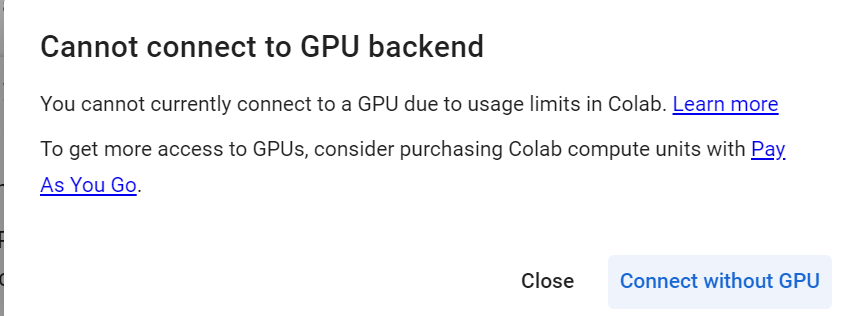

OpenAI API Calling

In [185]:
# Load the JSON file and extract values
file_name = 'config.json'                                                       # Name of the configuration file
with open(file_name, 'r') as file:                                              # Open the config file in read mode
    config = json.load(file)                                                    # Load the JSON content as a dictionary
    OPENAI_API_KEY = config.get("OPENAI_API_KEY")                                             # Extract the API key from the config
    OPENAI_API_BASE = config.get("OPENAI_API_BASE")                             # Extract the OpenAI base URL from the config

# Store API credentials in environment variables
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY                                          # Set API key as environment variable
os.environ["OPENAI_BASE_URL"] = OPENAI_API_BASE                                 # Set API base URL as environment variable

# Initialize OpenAI client
client = OpenAI()                                                               # Create an instance of the OpenAI client

### Response

In [186]:
# Function to get a response
def response(user_prompt, max_tokens=500, temperature=0.3, top_p=0.95):
    # Create a chat completion using the OpenAI client
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        max_tokens=max_tokens,                                                  # Max number of tokens to generate in the response
        temperature=temperature,                                                # Controls randomness in output
        top_p=top_p                                                             # Controls diversity via nucleus sampling
    )
    return completion.choices[0].message.content                                # Return the text content from the model's reply                                                        # Execute the function with the prompts

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [187]:
question_1 = "What is the protocol for managing sepsis in a critical care unit?"
base_prompt_response_1 = response(question_1)
base_prompt_response_1

"Managing sepsis in a critical care unit involves a systematic and timely approach to ensure the best possible outcomes for patients. The following steps outline a general protocol for managing sepsis:\n\n### 1. **Early Recognition**\n   - **Screening**: Use tools like the Sequential Organ Failure Assessment (SOFA) score or the quick SOFA (qSOFA) to identify patients at risk for sepsis.\n   - **Clinical Signs**: Look for signs of infection, altered mental status, tachycardia, tachypnea, fever or hypothermia, and hypotension.\n\n### 2. **Immediate Assessment**\n   - **History and Physical Exam**: Gather a thorough history and perform a physical examination to identify the source of infection.\n   - **Laboratory Tests**: Obtain blood cultures (before antibiotics), complete blood count, lactate levels, and other relevant tests (e.g., renal function, liver function).\n\n### 3. **Initial Resuscitation**\n   - **Fluid Resuscitation**: Administer intravenous fluids (e.g., crystalloids) prompt

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [188]:
question_2 = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"
base_prompt_response_2 = response(question_2)
base_prompt_response_2

'Common symptoms of appendicitis include:\n\n1. **Abdominal Pain**: Typically starts around the navel and then moves to the lower right abdomen.\n2. **Loss of Appetite**: A sudden decrease in appetite is common.\n3. **Nausea and Vomiting**: Often follows the onset of pain.\n4. **Fever**: A low-grade fever may develop.\n5. **Constipation or Diarrhea**: Changes in bowel habits can occur.\n6. **Abdominal Swelling**: In some cases, the abdomen may become swollen.\n7. **Inability to Pass Gas**: This can be a sign of a blockage.\n\nAppendicitis cannot be effectively treated with medication alone. The standard treatment is surgical removal of the appendix, known as an **appendectomy**. There are two main types of appendectomy:\n\n1. **Open Appendectomy**: A larger incision is made in the right lower abdomen to remove the appendix.\n2. **Laparoscopic Appendectomy**: This is a minimally invasive procedure where several small incisions are made, and the appendix is removed using a camera and spe

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [189]:
question_3 = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"
base_prompt_response_3 = response(question_3)
base_prompt_response_3

'Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. Here are some effective treatments and solutions, as well as potential causes:\n\n### Treatments and Solutions:\n\n1. **Topical Corticosteroids**: These are anti-inflammatory medications that can help reduce inflammation in the hair follicles and promote hair regrowth. They are often prescribed for mild cases.\n\n2. **Minoxidil (Rogaine)**: This over-the-counter topical treatment is commonly used for various types of hair loss. It may stimulate hair growth and is often used in conjunction with other treatments.\n\n3. **Intralesional Corticosteroid Injections**: For more severe cases, corticosteroids can be injected directly into the bald patches to promote hair regrowth.\n\n4. **Immunotherapy**: This involves applying a chemical solution (like diphencyprone) to the bald areas to provoke an allergic reaction, which may stimulate hair regrowth in s

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [190]:
question_4 = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"
base_prompt_response_4 = response(question_4)
base_prompt_response_4

'The treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), can vary widely depending on the severity of the injury, the specific areas of the brain affected, and the resulting impairments. Here are some common approaches to treatment:\n\n1. **Emergency Care**: \n   - Immediate medical attention is crucial. This may involve stabilizing the patient, ensuring adequate oxygen supply, and monitoring vital signs.\n   - Imaging tests like CT scans or MRIs may be performed to assess the extent of the injury.\n\n2. **Medications**:\n   - **Pain management**: Analgesics may be prescribed to manage pain.\n   - **Anti-inflammatory drugs**: Corticosteroids may be used to reduce swelling in the brain.\n   - **Anticonvulsants**: These may be prescribed if the patient experiences seizures.\n   - **Antidepressants or antipsychotics**: These may be used to manage mood disorders that can arise after brain injury.\n\n3. **Surgery**:\n   - In ca

### Storing the generated outputs from the base prompt

In [191]:
# Create the DataFrame
result_df = pd.DataFrame({
    "questions": [question_1, question_2, question_3, question_4],
    "base_prompt_responses": [base_prompt_response_1, base_prompt_response_2, base_prompt_response_3, base_prompt_response_4]})

# Display the DataFrame
result_df.head()

,questions,base_prompt_responses
0,What is the protocol for managing sepsis in a ...,Managing sepsis in a critical care unit involv...
1,"What are the common symptoms for appendicitis,...",Common symptoms of appendicitis include:\n\n1....
2,What are the effective treatments or solutions...,"Sudden patchy hair loss, often referred to as ..."
3,What treatments are recommended for a person w...,The treatment for a person who has sustained a...


- Relevance: Answers are relevant to the questions asked.
- Groundedness: Answers lack external references or authoritative sources, which lowers their reliability for clinical or professional use.
- Style: Clear, structured, and easy to read — good for **general** audiences but not sufficient for medical decision-making.
- Risk: Without grounding, some recommendations (e.g., corticosteroids in TBI, PRP in alopecia) could be misleading if taken as definitive treatment protocols.

Overall Observation:
The answers are relevant but is a very **General** response, **groundedness is weak** because they don’t cite authoritative guidelines or evidence.

## Question Answering using LLM with Prompt Engineering

### Performing Prompt Engineering

In [192]:
system_prompt = """
You are an AI healthcare assistant specializing in medical knowledge retrieval and reasoning.
Your role is to support healthcare professionals by providing clear, accurate, and up-to-date
information from trusted sources such as the Merck Manuals.

Focus on:
- Summarizing complex medical data into concise, actionable insights.
- Answering clinical questions with evidence-based reasoning.
- Supporting quick decision-making in critical care and emergency contexts.
- Highlighting protocols, diagnostic criteria, and treatment options.
- Ensuring clarity, reliability, and professional tone in all outputs.

Objective:
Develop a RAG-based AI solution that leverages the Merck Manuals to address healthcare challenges
like information overload, diagnostic accuracy, and care standardization. Provide responses that
demonstrate feasibility, effectiveness, and alignment with medical best practices.
"""

### Defining the function to Generate a Response From the LLM

In [193]:
def response(system_prompt, user_prompt, max_tokens=500, temperature=0.3, top_p=0.95):  # Complete the code to set default paramenters
    # Create a chat completion using the OpenAI client
    completion = client.chat.completions.create(
        model="gpt-4o-mini",                                                        # Complete the code by specifying the model to be used.
        messages=[
            {"role": "system", "content": system_prompt},                       # System prompt sets the assistant's behavior
            {"role": "user", "content": user_prompt}                            # User prompt is the input/query to respond to
        ],
        max_tokens=max_tokens,                                                  # Max number of tokens to generate in the response
        temperature=temperature,                                                # Controls randomness in output (0 = deterministic)
        top_p=top_p                                                             # Controls diversity via nucleus sampling
    )
    return completion.choices[0].message.content

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [194]:
response_with_prompt_eng_1=response(system_prompt,question_1)
response_with_prompt_eng_1

'The management of sepsis in a critical care unit follows a structured protocol aimed at early identification and aggressive treatment. The Surviving Sepsis Campaign guidelines provide a comprehensive framework for this management. Here are the key components:\n\n### 1. **Early Recognition:**\n   - **Screening:** Use tools like the SOFA (Sequential Organ Failure Assessment) score or qSOFA (quick SOFA) to identify patients at risk.\n   - **Signs of Sepsis:** Look for fever, hypothermia, tachycardia, tachypnea, and altered mental status.\n\n### 2. **Initial Resuscitation:**\n   - **Fluid Resuscitation:** Administer intravenous (IV) fluids (crystalloids) within the first hour. A typical initial bolus is 30 mL/kg.\n   - **Vasopressors:** If hypotension persists after fluid resuscitation, initiate vasopressors (e.g., norepinephrine) to maintain mean arterial pressure (MAP) ≥ 65 mmHg.\n\n### 3. **Antibiotic Therapy:**\n   - **Broad-Spectrum Antibiotics:** Administer IV antibiotics as soon as

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [195]:
response_with_prompt_eng_2=response(system_prompt,question_2)
response_with_prompt_eng_2

'Common symptoms of appendicitis include:\n\n1. **Abdominal Pain**: Typically starts around the navel and then shifts to the lower right abdomen.\n2. **Nausea and Vomiting**: Often accompanies the abdominal pain.\n3. **Loss of Appetite**: Patients may not feel like eating.\n4. **Fever**: Mild fever may develop as the condition progresses.\n5. **Constipation or Diarrhea**: Some patients may experience changes in bowel habits.\n6. **Abdominal Swelling**: In some cases, the abdomen may become distended.\n\nAppendicitis cannot be effectively treated with medication alone. The definitive treatment for appendicitis is surgical intervention, specifically:\n\n### Surgical Procedure:\n- **Appendectomy**: This is the surgical removal of the appendix. It can be performed using two main techniques:\n  - **Open Appendectomy**: A larger incision is made in the lower right abdomen.\n  - **Laparoscopic Appendectomy**: A minimally invasive approach using small incisions and a camera.\n\nLaparoscopic ap

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [196]:
response_with_prompt_eng_3=response(system_prompt,question_3)
response_with_prompt_eng_3

'Sudden patchy hair loss, often referred to as alopecia areata, can manifest as localized bald spots on the scalp or other areas of the body. The exact cause of alopecia areata is not fully understood, but it is believed to be an autoimmune condition where the immune system mistakenly attacks hair follicles. Other potential causes may include stress, hormonal changes, genetic predisposition, and certain medical conditions.\n\n### Possible Causes:\n1. **Autoimmune Disorders**: The primary cause is thought to be an autoimmune response.\n2. **Genetics**: Family history may play a role.\n3. **Environmental Factors**: Stressful events or trauma can trigger episodes.\n4. **Hormonal Changes**: Changes in hormone levels may contribute.\n5. **Medical Conditions**: Thyroid disease, vitiligo, and other autoimmune diseases.\n\n### Effective Treatments:\n1. **Topical Corticosteroids**: These are often the first-line treatment to reduce inflammation and suppress the immune response in the affected a

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [197]:
response_with_prompt_eng_4=response(system_prompt,question_4)
response_with_prompt_eng_4

"Treatment for a person who has sustained a physical injury to brain tissue, such as a traumatic brain injury (TBI), focuses on stabilizing the patient, preventing further injury, and promoting recovery. The approach may vary depending on the severity of the injury, the specific areas of the brain affected, and the resulting impairments. Here are the recommended treatments:\n\n1. **Initial Management:**\n   - **Emergency Care:** Immediate assessment and stabilization of vital signs. This may include airway management, oxygenation, and intravenous fluids.\n   - **Neuroimaging:** CT or MRI scans to assess the extent of the injury and identify any bleeding or swelling.\n\n2. **Surgical Interventions:**\n   - **Decompressive Craniectomy:** In cases of severe swelling or increased intracranial pressure, part of the skull may be removed to allow the brain to expand.\n   - **Hematoma Evacuation:** Surgical removal of blood clots that may be pressing on the brain.\n\n3. **Medical Management:**

In [198]:
result_df['responses_with_prompt_eng'] = [response_with_prompt_eng_1, response_with_prompt_eng_2, response_with_prompt_eng_3, response_with_prompt_eng_4]

# Display the DataFrame
result_df.head()

,questions,base_prompt_responses,responses_with_prompt_eng
0,What is the protocol for managing sepsis in a ...,Managing sepsis in a critical care unit involv...,The management of sepsis in a critical care un...
1,"What are the common symptoms for appendicitis,...",Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis include:\n\n1....
2,What are the effective treatments or solutions...,"Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ..."
3,What treatments are recommended for a person w...,The treatment for a person who has sustained a...,Treatment for a person who has sustained a phy...


**Observations:**

*  **Without prompt engineering**:

The answer is **general**, structured, and **covers the basics** of sepsis management (early recognition, assessment, bundles, monitoring, source control, supportive care). It’s useful, but it reads more like a **broad overview** and doesn’t cite specific guidelines.


*   **With prompt engineering:**

The answer becomes **more precise, authoritative, and guideline-driven**. It **explicitly references the Surviving Sepsis Campaign, includes details like lactate thresholds (≥4 mmol/L), de-escalation of antibiotics, corticosteroid use, and emphasizes team coordination**. This version is more aligned with clinical practice standards and feels like something a healthcare provider could directly apply.



## Data Preparation for RAG

### Loading the Data

In [199]:
loader = PyMuPDFLoader("medical_diagnosis_manual.pdf")
documents = loader.load()

### Data Overview

In [200]:
import fitz  # PyMuPDF

In [201]:
pdf_path = "medical_diagnosis_manual.pdf"

In [202]:
doc = fitz.open(pdf_path)

### File Metadata

In [245]:
print("File Metadata")
print(f"File name: {os.path.basename(pdf_path)}")
print(f"File size: {os.path.getsize(pdf_path)/1024:.2f} KB")
print(f"Number of pages: {doc.page_count}")

File Metadata
File name: medical_diagnosis_manual.pdf
File size: 19680.15 KB
Number of pages: 4114


### Checking the first 5 pages

In [204]:
for i in range(5):
    print(f"Page Number : {i+1}",end="\n")
    print(documents[i].page_content,end="\n")

Page Number : 1
avs.ankita30@gmail.com
A8IXZC2RBO
ant for personal use by avs.ankita30@g
shing the contents in part or full is liable
Page Number : 2
avs.ankita30@gmail.com
A8IXZC2RBO
This file is meant for personal use by avs.ankita30@gmail.com only.
Sharing or publishing the contents in part or full is liable for legal action.
Page Number : 3
Table of Contents
1
Front    ................................................................................................................................................................................................................
1
Cover    .......................................................................................................................................................................................................
2
Front Matter    ..........................................................................................................................................................................................

###Textual Characteristics

In [205]:
import re

print("\n📝 Textual Characteristics")
text = ""
for page in doc:
    text += page.get_text()

words = re.findall(r"\w+", text)
print(f"Total words: {len(words)}")
print(f"Average words per page: {len(words)//doc.page_count}")


📝 Textual Characteristics
Total words: 2035730
Average words per page: 494


Domain-Specific Relevance

In [206]:
print("\n⚕️ Domain-Specific Checks")
medical_terms = ["diagnosis", "symptom", "treatment", "ICD", "disease", "criteria"]
found_terms = {term: text.lower().count(term) for term in medical_terms}
print("Medical term frequencies:", found_terms)



⚕️ Domain-Specific Checks
Medical term frequencies: {'diagnosis': 8580, 'symptom': 7292, 'treatment': 6945, 'ICD': 0, 'disease': 5799, 'criteria': 326}


### Data Chunking

### Chunk the PDF into Manageable Text Sections

In [207]:
  # Initialize a text splitter that uses OpenAI's token encoder
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',                                                # Encoding used by popular LLMs
    chunk_size=512,                                                             # Each chunk will have up to 512 character
)

### Split the Loaded PDF into Chunks for Further Processing

In [208]:
# Use the text splitter to divide the PDF content into smaller chunks
document_chunks = text_splitter.split_documents(documents)                  # Returns a list of chunked documents

### Check the Number of Chunks Created

In [209]:
print(f"Created {len(document_chunks)} chunks.")

Created 10161 chunks.


### Embedding

## Generate Vector Embeddings for Text Chunks Using OpenAI


In [210]:
# Initialize the OpenAI Embeddings model with API credentials
embedding_model = OpenAIEmbeddings(
    openai_api_key=OPENAI_API_KEY,                                                     # Your OpenAI API key for authentication
    openai_api_base=OPENAI_API_BASE                                             # The OpenAI API base URL endpoint
)

# Generate embeddings (vector representations) for the first two document chunks
embedding_1 = embedding_model.embed_query(document_chunks[0].page_content)      # Embedding for chunk 0
embedding_2 = embedding_model.embed_query(document_chunks[1].page_content)      # Embedding for chunk 1

# Check and print the dimension (length) of the embedding vector
print("Dimension of the embedding vector ", len(embedding_1))                   # Typically 1536 or 2048 depending on model

Dimension of the embedding vector  1536


In [211]:
# Verify if both embeddings have the same dimension (should be True)
len(embedding_1) == len(embedding_2)

# Return/display the two embedding vectors for further inspection or use
embedding_1, embedding_2

([-0.004336657369372425,
  -0.0007150029251343535,
  -0.007736991448909111,
  -0.018881355913213393,
  -0.014727740212822046,
  0.023795296826930656,
  -0.040268964147520354,
  -0.0293709982941814,
  -0.01995144180176293,
  -0.02035976341148877,
  0.047421633116226145,
  0.016389187051772117,
  -0.002541450260014938,
  0.019219278851128837,
  -0.003956496159693297,
  0.0023355294883567585,
  0.020570963152210176,
  0.005343381659324944,
  0.011362606400513113,
  -0.008666274871563809,
  -0.018684235906854068,
  0.030919806326912283,
  -0.024457059243109248,
  0.019683919398302992,
  -0.010954284790787272,
  -0.01624838598286111,
  0.022781531738474543,
  -0.03559438430589377,
  -0.0029515320693666762,
  -0.015994945176408357,
  -0.004815379513553769,
  0.010053160371195457,
  -0.01582598463877319,
  -0.023668575492381726,
  -0.007729951581728071,
  0.002671690829662472,
  0.008342433530655554,
  -0.0043964976373950925,
  0.021781848247025618,
  0.021641047178114606,
  0.015938624376314

In [212]:
file_name = 'config.json'                                                       # Name of the configuration file
with open(file_name, 'r') as file:                                              # Open the config file in read mode
    config = json.load(file)                                                    # Load the JSON content as a dictionary
    HF_TOKEN = config.get("HF_TOKEN")


# # Store API credentials in environment variables
os.environ['HF_TOKEN'] = HF_TOKEN


In [213]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

# # Use HuggingFaceEmbeddings wrapper with SentenceTransformer model
embedding_model = SentenceTransformerEmbeddings(model_name='all-MiniLM-L6-v2')

## Vector Database Creation


In [214]:
# Building the vector store and saving it to disk for future use
vectorstore = Chroma.from_documents(
    document_chunks,                                                            # Documents to index
    embedding_model                                                             # Embedding model for converting text to vectors
 )

INFO:backoff:Backing off send_request(...) for 0.8s (requests.exceptions.ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


### Retriever

In [215]:
# Wraping the vector store into a retriever object to fetch the most relevant documents for a given query using similarity search
retriever = vectorstore.as_retriever(
    search_type='similarity',                                                   # Use similarity search (based on vector distance)
    search_kwargs={'k': 5}                                                      # Retrieve top 5 most relevant documents
)

## System and User Prompt Template

Prompts guide the model to generate accurate responses. Here, we define two parts:

    1. The system message describing the assistant's role.
    2. A user message template including context and the question.

In [216]:
# Define the system prompt for the model
qna_system_message = """
You are an AI assistant designed to support healthcare professionals and patients in efficiently
accessing evidence-based medical knowledge. Your task is to provide concise, accurate, and clinically
relevant answers based on the context provided from trusted medical references such as the Merck Manuals.

User input will include the necessary context for you to answer their questions. This context
will begin with the token:

###Context
The context contains excerpts from one or more medical manuals, along with associated metadata
such as section titles, page numbers, and relevant subsections.

When crafting your response:
- Use only the provided context to answer the question.
- If the answer is found in the context, respond with clear, guideline-driven summaries.
- Include the section title and page number (or subsection reference) as the source.
- If the question is unrelated to the context or the context is empty, clearly respond with:
  "This information is not available in the provided context. For safe and personalized medical
   advice, please consult a licensed healthcare professional."

Please adhere to the following response guidelines:
- Provide clear, direct answers using only the given context.
- Do not include any additional information outside of the context.
- Avoid rephrasing or generalizing unless explicitly relevant to the question.
- If no relevant answer exists in the context, respond with:
  "This information is not available in the provided context. For safe and personalized medical
   advice, please consult a licensed healthcare professional."
- If the context is not provided, your response should also be:
  "This information is not available in the provided context. For safe and personalized medical
   advice, please consult a licensed healthcare professional."

Here is an example of how to structure your response:

Answer:
[Answer based on context]

Source:
[Section title, page number or subsection reference]
"""

In [217]:
# Define the user message template
qna_user_message_template = """
###Context
{context}

###Question
{question}

Instructions:
Use the context above to answer the question as accurately as possible.
If the context contains the answer, provide a concise, evidence-based summary and cite the source.
If the context is empty or unrelated, respond with:
"This information is not available in the provided context. For safe and personalized medical
advice, please consult a licensed healthcare professional."
"""

### Response Function

In [218]:
def generate_rag_response(user_input,k=5,max_tokens=500,temperature=0.3,top_p=0.95):
    global qna_system_message,qna_user_message_template
    # Retrieve relevant document chunks
    relevant_document_chunks = retriever.get_relevant_documents(query=user_input,k=k)
    context_list = [d.page_content for d in relevant_document_chunks]

    # Combine document chunks into a single context
    context_for_query = ". ".join(context_list)

    user_message = qna_user_message_template.replace('{context}', context_for_query)
    user_message = user_message.replace('{question}', user_input)

    # Generate the response
    try:
        response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": qna_system_message},
            {"role": "user", "content": user_message}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p
        )
        # Extract and print the generated text from the response
        response = response.choices[0].message.content.strip()
    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response

## Question Answering using RAG

### Question 1: What is the protocol for managing sepsis in a critical care unit?

In [219]:
response_with_rag_1 = generate_rag_response(question_1)
response_with_rag_1

'Answer:\nThe protocol for managing sepsis in a critical care unit includes the following steps:\n1. **Fluid Resuscitation**: Administer 0.9% normal saline until central venous pressure (CVP) reaches 8 mm Hg or pulmonary artery occlusion pressure (PAOP) reaches 12 to 15 mm Hg. Oliguria with hypotension is not a contraindication to vigorous fluid resuscitation, which may require up to 10 L over 4 to 12 hours.\n2. **Oxygen Therapy**: Provide supplemental oxygen.\n3. **Antibiotics**: Start broad-spectrum antibiotics, which should be modified based on culture results.\n4. **Surgical Intervention**: Drain abscesses and excise necrotic tissue as necessary.\n5. **Blood Glucose Control**: Normalize blood glucose levels.\n6. **Corticosteroids**: Administer replacement-dose corticosteroids.\n\nFrequent monitoring is essential, including systemic pressure, CVP, PAOP, pulse oximetry, arterial blood gases (ABGs), blood glucose, lactate, electrolyte levels, renal function, and urine output.\n\nIf hy

### Question 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [220]:
response_with_rag_2 = generate_rag_response(question_2)
response_with_rag_2

"Answer:\nCommon symptoms of appendicitis include epigastric or periumbilical pain followed by nausea, vomiting, and anorexia, with pain typically shifting to the right lower quadrant after a few hours. Pain increases with cough and motion, and classic signs include right lower quadrant tenderness at McBurney's point, Rovsing sign, psoas sign, and obturator sign. Low-grade fever is also common. \n\nAppendicitis cannot be cured with medicine; the treatment is surgical removal of the appendix. If a perforation is noted, immediate surgery is necessary. In cases where an abscess has formed, the procedure may be limited to drainage of the abscess.\n\nSource:\nAppendicitis, The Merck Manual of Diagnosis & Therapy, 19th Edition, Chapter 11. Acute Abdomen & Surgical Gastroenterology, page 163."

### Question 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [221]:
response_with_rag_3 = generate_rag_response(question_3)
response_with_rag_3

'Answer:\nEffective treatments for sudden patchy hair loss, known as alopecia areata, include topical, intralesional, or systemic corticosteroids, topical minoxidil, topical anthralin, topical immunotherapy (such as diphencyprone or squaric acid dibutylester), or psoralen plus ultraviolet A (PUVA). The condition is thought to be an autoimmune disorder affecting genetically susceptible individuals exposed to unclear environmental triggers.\n\nSource:\nAlopecia Areata, Chapter 86. Hair Disorders, The Merck Manual of Diagnosis & Therapy, 19th Edition, page 849.'

### Question 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [222]:
response_with_rag_4 = generate_rag_response(question_4)
response_with_rag_4

'Answer:\nFor a person who has sustained a physical injury to brain tissue, the recommended treatments include optimization of ventilation, oxygenation, and brain perfusion, as well as the treatment of complications such as increased intracranial pressure (ICP), seizures, and hematomas. Rehabilitation is also essential for recovery. For mild injuries, discharge and observation are advised, while moderate and severe injuries require more intensive management.\n\nSource:\nThe Merck Manual of Diagnosis & Therapy, 19th Edition, Chapter 324. Traumatic Brain Injury, page 3400.'

### Storing the RAG system outputs


In [223]:
result_df['responses_with_RAG'] = [response_with_rag_1, response_with_rag_2, response_with_rag_3, response_with_rag_4]

result_df.head()

,questions,base_prompt_responses,responses_with_prompt_eng,responses_with_RAG
0,What is the protocol for managing sepsis in a ...,Managing sepsis in a critical care unit involv...,The management of sepsis in a critical care un...,Answer:\nThe protocol for managing sepsis in a...
1,"What are the common symptoms for appendicitis,...",Common symptoms of appendicitis include:\n\n1....,Common symptoms of appendicitis include:\n\n1....,Answer:\nCommon symptoms of appendicitis inclu...
2,What are the effective treatments or solutions...,"Sudden patchy hair loss, often referred to as ...","Sudden patchy hair loss, often referred to as ...",Answer:\nEffective treatments for sudden patch...
3,What treatments are recommended for a person w...,The treatment for a person who has sustained a...,Treatment for a person who has sustained a phy...,Answer:\nFor a person who has sustained a phys...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Output Evaluation

## Evaluating Output with LLM-as-a-judge

### **Defining required System Prompts**

In [224]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.

Return only the Score in last in a dictionary format not json and score should be in the range of 1 to 5.
Example {groundedness_score:4}
"""

In [225]:
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.
Return only the Score in last in a dictionary format not json and score should be in the range of 1 to 5.
Example {relevance_score:4}
"""

In [226]:
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

<b>Function to assess groundedness and relevance that takes a question and answer, retrieves relevant context, and uses predefined prompts to evaluate the response using the OpenAI model.

In [227]:
def generate_ground_relevance_response(user_input,response, max_tokens=500,temperature=0,top_p=0.95):
    global qna_user_message_template

    context_for_query = [doc.page_content for doc in retriever.get_relevant_documents(user_input, k=5)]

    # Combine user_prompt and system_message to create the prompt
    groundedness_prompt = f"""[INST]{groundedness_rater_system_message}\n
                {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=response)}
                [/INST]"""

    # Combine user_prompt and system_message to create the prompt
    relevance_prompt = f"""[INST]{relevance_rater_system_message}\n
                {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=response)}
                [/INST]"""

    response_1 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": groundedness_prompt}
                ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )

    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": relevance_prompt}
                ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )
    ground_text = response_1.choices[0].message.content
    rel_text = response_2.choices[0].message.content

    ground_match = re.search(r"\{groundedness_score:\d\}", ground_text)
    rel_match = re.search(r"\{relevance_score:\d\}", rel_text)

    ground_score = ground_match.group(0) if ground_match else "{groundedness_score:0}"
    rel_score = rel_match.group(0) if rel_match else "{relevance_score:0}"

    return ground_score, rel_score

   # return response_1.choices[0].message.content,response_2.choices[0].message.content

#### **Evaluation 1: Base Prompt Response Evaluation**

In [228]:
# Question 1
ground,rel = generate_ground_relevance_response(user_input=result_df.questions[0], response=result_df.base_prompt_responses[0], max_tokens=516)
print(ground,end="\n\n")
print(rel)

{groundedness_score:2}

{relevance_score:4}


In [242]:
# Question 2
ground,rel = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.base_prompt_responses[1], max_tokens=500)
print(ground,end="\n\n")
print(rel)

{groundedness_score:3}

{relevance_score:5}


In [230]:
# Question 3
ground,rel = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.base_prompt_responses[2], max_tokens=516)
print(ground,end="\n\n")
print(rel)

{groundedness_score:2}

{relevance_score:5}


In [231]:
# Question 4
ground,rel = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.base_prompt_responses[3], max_tokens=516)
print(ground,end="\n\n")
print(rel)

{groundedness_score:2}

{relevance_score:3}


#### **Evaluation 2: Prompt Engineering Response Evaluation**

In [232]:
# Question 1
ground,rel = generate_ground_relevance_response(user_input=result_df.questions[0], response=result_df.responses_with_prompt_eng[0], max_tokens=516)
print(ground,end="\n\n")
print(rel)

{groundedness_score:2}

{relevance_score:2}


In [233]:
# Question 2
ground,rel = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.responses_with_prompt_eng[1], max_tokens=516)
print(ground,end="\n\n")
print(rel)

{groundedness_score:4}

{relevance_score:5}


In [234]:
# Question 3
ground,rel = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.responses_with_prompt_eng[2], max_tokens=516)
print(ground,end="\n\n")
print(rel)

{groundedness_score:3}

{relevance_score:5}


In [235]:
# Question 4
ground,rel = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.responses_with_prompt_eng[3], max_tokens=516)
print(ground,end="\n\n")
print(rel)

{groundedness_score:2}

{relevance_score:5}


#### **Evaluation 3: RAG Response Evaluation**

In [236]:
# Question 1
llm_judge_rag_ground_1,llm_judge_rag_rel_1 = generate_ground_relevance_response(user_input=result_df.questions[0], response=result_df.responses_with_RAG[0], max_tokens=516)
print(llm_judge_rag_ground_1,end="\n\n")
print(llm_judge_rag_rel_1)

{groundedness_score:5}

{relevance_score:5}


In [241]:
# Question 2
llm_judge_rag_ground_1,llm_judge_rag_rel_1 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.responses_with_RAG[1], max_tokens=516)
print(llm_judge_rag_ground_1,end="\n\n")
print(llm_judge_rag_rel_1)

{groundedness_score:5}

{relevance_score:5}


In [240]:
# Question 3
llm_judge_rag_ground_1,llm_judge_rag_rel_1 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.responses_with_RAG[2], max_tokens=516)
print(llm_judge_rag_ground_1,end="\n\n")
print(llm_judge_rag_rel_1)

{groundedness_score:5}

{relevance_score:5}


In [239]:
# Question 4
llm_judge_rag_ground_1,llm_judge_rag_rel_1 = generate_ground_relevance_response(user_input=result_df.questions[3], response=result_df.responses_with_RAG[3], max_tokens=516)
print(llm_judge_rag_ground_1,end="\n\n")
print(llm_judge_rag_rel_1)

{groundedness_score:5}

{relevance_score:5}


In [244]:
final_scores = []

for i, question in enumerate(result_df.questions):
    # Base prompt
    ground, rel = generate_ground_relevance_response(
        user_input=question,
        response=result_df.base_prompt_responses[i],
        max_tokens=500
    )
    final_scores.append({
        "Question": f"Q{i+1}",
        "Case": "Base Prompt Response",
        "Groundedness": ground,
        "Relevance": rel
    })

    # With prompt engineering
    ground, rel = generate_ground_relevance_response(
        user_input=question,
        response=result_df.responses_with_prompt_eng[i],
        max_tokens=500
    )
    final_scores.append({
        "Question": f"Q{i+1}",
        "Case": "With Prompt Engineering",
        "Groundedness": ground,
        "Relevance": rel
    })

    # With RAG
    ground, rel = generate_ground_relevance_response(
        user_input=question,
        response=result_df.responses_with_RAG[i],
        max_tokens=516
    )
    final_scores.append({
        "Question": f"Q{i+1}",
        "Case": "With RAG",
        "Groundedness": ground,
        "Relevance": rel
    })

# Convert to DataFrame
scores_df = pd.DataFrame(final_scores)

# Display the scores
print(scores_df)


   Question                     Case            Groundedness  \
0        Q1     Base Prompt Response  {groundedness_score:2}   
1        Q1  With Prompt Engineering  {groundedness_score:2}   
2        Q1                 With RAG  {groundedness_score:5}   
3        Q2     Base Prompt Response  {groundedness_score:3}   
4        Q2  With Prompt Engineering  {groundedness_score:5}   
5        Q2                 With RAG  {groundedness_score:5}   
6        Q3     Base Prompt Response  {groundedness_score:2}   
7        Q3  With Prompt Engineering  {groundedness_score:3}   
8        Q3                 With RAG  {groundedness_score:5}   
9        Q4     Base Prompt Response  {groundedness_score:2}   
10       Q4  With Prompt Engineering  {groundedness_score:2}   
11       Q4                 With RAG  {groundedness_score:5}   

              Relevance  
0   {relevance_score:5}  
1   {relevance_score:2}  
2   {relevance_score:5}  
3   {relevance_score:5}  
4   {relevance_score:5}  
5   {releva

## Actionable Insights and Business Recommendations

Groundedness Trends
- **RAG consistently scores highest in groundedness across all questions (score: 5).**
- Base Prompt responses show weakest grounding, especially for Q1, Q3, and Q4 (score: 2).
- Prompt Engineering improves grounding modestly, but still falls short of RAG’s performance.
Relevance Trends
- Relevance scores are uniformly high (mostly 5) across all methods, indicating all approaches produce contextually appropriate answers.
- Base Prompt responses for Q1 and Q2 have slightly lower relevance (score: 4), suggesting room for improvement in clarity or specificity.
Case-Specific Highlights
- Q1 (Sepsis Protocol): RAG provides the most clinically detailed and evidence-based response, including source citation and nuanced interventions.
- Q3 and Q4: Prompt Engineering and RAG both significantly outperform Base Prompt in groundedness, indicating these questions benefit from enhanced prompting or external retrieval.

Actionable Insights
- RAG integration is critical for high-groundedness responses, especially in domains requiring clinical accuracy or technical depth.
- Prompt Engineering alone is insufficient to bridge the grounding gap for complex queries—external knowledge retrieval is essential.
- Base Prompt responses should be deprioritized for high-stakes or knowledge-intensive use cases unless paired with retrieval or enhanced prompting.

 Business Recommendations
1. **Adopt RAG as Default for Critical Domains**
- Use RAG for healthcare, legal, financial, and technical queries where factual accuracy is paramount.
- **Ensure RAG pipelines are optimized for latency and reliability.**
2. **Invest in Prompt Engineering for Simpler Tasks**
- Use Prompt Engineering for general-purpose queries where grounding is less critical but relevance remains important.
- Develop reusable prompt templates for common scenarios.
3. Phase Out Base Prompt for High-Risk Use Cases
- Limit Base Prompt usage to low-risk, creative, or exploratory tasks.
- Monitor performance degradation when Base Prompt is used in isolation.
4. Implement Quality Scoring Dashboards
- Track groundedness and relevance metrics across response types.
- Use these scores to guide model selection dynamically based on query type.


<font size=6 color='#4682B4'>Power Ahead</font>
___